In [ ]:
# 引入依赖包
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 200
%matplotlib inline

In [ ]:
# 初始化文本集与标签集
corpus = ['The sky is blue and beautiful.',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
          'I love green eggs, ham, sausages and bacon!',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick!'    
]
labels = ['weather', 'weather', 'animals', 'food', 'food', 'animals', 'weather', 'animals']


In [ ]:
# 将文本集和标签集标识为数据框架的格式
corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus,'Category': labels})
corpus_df = corpus_df[['Document','Category']]

In [ ]:
corpus_df

,Document,Category
0,The sky is blue and beautiful.,weather
1,Love this blue and beautiful sky!,weather
2,The quick brown fox jumps over the lazy dog.,animals
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food
4,"I love green eggs, ham, sausages and bacon!",food
5,The brown fox is quick and the blue dog is lazy!,animals
6,The sky is very blue and the sky is very beautiful today,weather
7,The dog is lazy but the brown fox is quick!,animals


In [ ]:
# 简单的文本预处理流程介绍
wpt = nltk.WordPunctTokenizer()
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

  # 全小写化
  # 移除特殊字符
  # 移除空格
  # 删除停用词
def normalize_document(doc):
  doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
  doc = doc.lower()
  doc = doc.strip()
  # 对文档进行分词
  tokens = wpt.tokenize(doc)
  # 删除停用词
  filtered_tokens = [token for token in tokens if token not in stop_words]
  # 重新构建文档
  doc = ' '.join(filtered_tokens)
  return doc

normalize_corpus = np.vectorize(normalize_document)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
norm_corpus = normalize_corpus(corpus)
norm_corpus

array(['sky blue beautiful', 'love blue beautiful sky',
       'quick brown fox jumps lazy dog',
       'kings breakfast sausages ham bacon eggs toast beans',
       'love green eggs ham sausages bacon',
       'brown fox quick blue dog lazy', 'sky blue sky beautiful today',
       'dog lazy brown fox quick'], dtype='<U51')

In [ ]:
# 词嵌入流程
# 使用圣经作为输入文本集的样本

from nltk.corpus import gutenberg
nltk.download('gutenberg')
nltk.download('punkt')
from string import punctuation

bible = gutenberg.sents('bible-kjv.txt') 
remove_terms = punctuation + '0123456789'

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# 移除标点符号和数字的同时进行小写转化
norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]
# 文本内容拼接
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
# 使用normalize_corpus方法进行预处理操作
norm_bible = filter(None, normalize_corpus(norm_bible))
# 将通过分词处理后的圣经文本进行筛选，只留下长度大于2的圣经文本
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]

print('Total lines:', len(bible))
print('\nSample line:', bible[10])
print('\nProcessed line:', norm_bible[10])

Total lines: 30103

Sample line: ['1', ':', '6', 'And', 'God', 'said', ',', 'Let', 'there', 'be', 'a', 'firmament', 'in', 'the', 'midst', 'of', 'the', 'waters', ',', 'and', 'let', 'it', 'divide', 'the', 'waters', 'from', 'the', 'waters', '.']

Processed line: god said let firmament midst waters let divide waters waters


In [ ]:
# 使用CBOW实现word2vect模型

from keras.preprocessing import text
from keras.utils import np_utils
from keras.utils import pad_sequences


# tokenizer 对象首先将所有文本转换为小写
# 并去除标点符号等特殊字符
# 然后将文本拆分成单词，并为每个单词分配一个唯一的整数 ID
# 这些整数 ID 从 1 开始连续编号
# 最后tokenizer 对象会构建一个词汇表，其中包含所有出现过的单词及其对应的整数 ID
# 即使我们在之前已经对文本进行了预处理操作，这里主要是对文本转化为数字化的第一步
# 也就是构建字典转化为 one-hot vector
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)
word2id = tokenizer.word_index
# 给字典赋予一个pad标签用于填充
word2id['PAD'] = 0
# 将word与id构建键值对
id2word = {v:k for k, v in word2id.items()}
# 双重for循环
# 首先从处理好的bible中拿到单条的doc文档
# 对doc文档进行分词处理，不能说很有意义，因为我们已经做过很多步了
# 将分词之后的序列转化为基于字典的数字，也就是句子向量化
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]
vocab_size = len(word2id)
embed_size = 100
window_size = 2
print('Vocabulary Size:', vocab_size) # 展示字典大小
print('Vocabulary Sample:', list(word2id.items())[:10]) # 展示字典前十项

Vocabulary Size: 12425
Vocabulary Sample: [('shall', 1), ('unto', 2), ('lord', 3), ('thou', 4), ('thy', 5), ('god', 6), ('ye', 7), ('said', 8), ('thee', 9), ('upon', 10)]


In [ ]:
# 构建生成 上下文与目标词的文本对 函数

def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            # 基于window_size 填充context数组
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            # 原数组的全部文本就是 target words
            label_word.append(word)
            # 对边缘的文本场景所导致的上下文长度缺失问题，使用填充的方式解决
            x = pad_sequences(context_words, maxlen=context_length)
            # 将target/center word 转化为one-hot encoding
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)

In [ ]:
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ['old', 'testament', 'james', 'bible'] -> Target (Y): king
Context (X): ['first', 'book', 'called', 'genesis'] -> Target (Y): moses
Context (X): ['beginning', 'god', 'heaven', 'earth'] -> Target (Y): created
Context (X): ['earth', 'without', 'void', 'darkness'] -> Target (Y): form
Context (X): ['without', 'form', 'darkness', 'upon'] -> Target (Y): void
Context (X): ['form', 'void', 'upon', 'face'] -> Target (Y): darkness
Context (X): ['void', 'darkness', 'face', 'deep'] -> Target (Y): upon
Context (X): ['spirit', 'god', 'upon', 'face'] -> Target (Y): moved
Context (X): ['god', 'moved', 'face', 'waters'] -> Target (Y): upon
Context (X): ['god', 'said', 'light', 'light'] -> Target (Y): let
Context (X): ['god', 'saw', 'good', 'god'] -> Target (Y): light


In [ ]:
# 构建 CBOW NN网络结构

import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

cbow = Sequential()
# input_dim 是词汇表的大小
# output_dim 是输出向量的维度
# input_length 是输入序列的长度
# 对应网络结构中的 input layer 层
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
# 将上下文单词的嵌入向量相加
# 除以上下文单词的数量，得到一个平均嵌入向量，表示当前中心词的词向量
# 对应 网络结构中的 Hidden layer 层
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
# 将平均嵌入向量映射为一个概率分布
# 代表了词汇表中每个单词作为中心词的可能性
cbow.add(Dense(vocab_size, activation='softmax'))
# 使用交叉熵损失函数作为Loss
# 并使用rmsprop作为优化函数
cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')
print(cbow.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 4, 100)            1242500   
                                                                 
 lambda_1 (Lambda)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 12425)             1254925   
                                                                 
Total params: 2,497,425
Trainable params: 2,497,425
Non-trainable params: 0
_________________________________________________________________
None


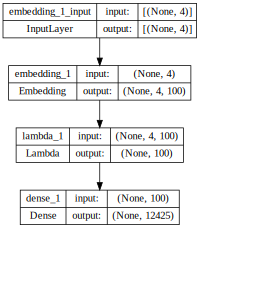

In [ ]:
# 绘制网络结构图

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(cbow, show_shapes=True, show_layer_names=True, 
                 rankdir='TB').create(prog='dot', format='svg'))

In [ ]:
# 模型训练

for epoch in range(1, 6):
    loss = 0.
    i = 0
    for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
        i += 1
        loss += cbow.train_on_batch(x, y)
        if i % 10000 == 0:
            print('Processed {} (context, word) pairs'.format(i))

    print('Epoch:', epoch, '\tLoss:', loss)
    print()

Processed 10000 (context, word) pairs
Processed 20000 (context, word) pairs
Processed 30000 (context, word) pairs
Processed 40000 (context, word) pairs
Processed 50000 (context, word) pairs
Processed 60000 (context, word) pairs
Processed 70000 (context, word) pairs
Processed 80000 (context, word) pairs
Processed 90000 (context, word) pairs
Processed 100000 (context, word) pairs
Processed 110000 (context, word) pairs
Processed 120000 (context, word) pairs
Processed 130000 (context, word) pairs
Processed 140000 (context, word) pairs
Processed 150000 (context, word) pairs
Processed 160000 (context, word) pairs
Processed 170000 (context, word) pairs
Processed 180000 (context, word) pairs
Processed 190000 (context, word) pairs
Processed 200000 (context, word) pairs
Processed 210000 (context, word) pairs
Processed 220000 (context, word) pairs


In [ ]:
# 取出CBOW 中训练好的词向量
weights = cbow.get_weights()[0]
weights = weights[1:]
print(weights.shape)

pd.DataFrame(weights, index=list(id2word.values())[1:]).head()

In [ ]:
# 构建文本距离矩阵，观察最相似的文本

from sklearn.metrics.pairwise import euclidean_distances

# 基于词向量矩阵构建欧氏距离矩阵
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

# 查询 words 的相似文本内容
similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}

similar_words

## 使用 Skip-Gram 实现 Word2Vect

In [ ]:
# 构建字典
from keras.preprocessing import text

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)

word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}

vocab_size = len(word2id) + 1 
embed_size = 100

wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 12425
Vocabulary Sample: [('shall', 1), ('unto', 2), ('lord', 3), ('thou', 4), ('thy', 5), ('god', 6), ('ye', 7), ('said', 8), ('thee', 9), ('upon', 10)]


In [ ]:
# 构建基于skipgram的上下文/目标词的文本对
from keras.preprocessing.sequence import skipgrams

# 生成skipgram文本对
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=10) for wid in wids]

# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id2word[pairs[i][0]], pairs[i][0], 
          id2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

In [ ]:
# 构建Skip-gram神经网络
from keras.layers import Concatenate
from keras.layers.core import Dense, Reshape
from keras.layers import Embedding
from keras.models import Sequential
# 将center word 和 context words 分别作为模型的层来处理
# skip gram 中我们使用 center word 预测 context word
# 这是一个1toN的问题
word_model = Sequential()
# 将输入的文本进行词嵌入处理，将文本数据中的每一个单词表示为一个向量
# 每一个单词会映射到一个对应的词向量上
# 词向量矩阵的初始化过程使用glorot uniform进行初始化 - Xavier 初始化
# “Xavier初始化” 是一种通过均匀分布来随机初始化权重参数的方法，
# 这个分布的范围被设计为[-limit, limit]，
# 其中limit的值为sqrt(6 / (fan_in + fan_out))，fan_in和fan_out分别是输入和输出的单元数
# Glorot Uniform初始化可以有效地避免梯度消失和梯度爆炸等问题，并且可以帮助加速模型的收敛
word_model.add(Embedding(vocab_size, embed_size,
                         embeddings_initializer="glorot_uniform",
                         input_length=1))
# 将 Embedding 层的输出转换为一个一维向量，用于后续处理
word_model.add(Reshape((embed_size, )))
# 
context_model = Sequential()
context_model.add(Embedding(vocab_size, embed_size,
                  embeddings_initializer="glorot_uniform",
                  input_length=1))
context_model.add(Reshape((embed_size,)))

model = Sequential()
# 创建一个合并模型，将center word model和context model 通过 dot 运算进行了拼接
# 使用dot运算来计算center word 和 context words 的 similarity
model.add(Concatenate([word_model, context_model], mode="dot"))
model.add(Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid"))
model.compile(loss="mean_squared_error", optimizer="rmsprop")
print(model.summary())

NameError: ignored

In [ ]:
## 绘制模型结构图
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

In [ ]:
# 训练模型
for epoch in range(1, 6):
    loss = 0
    for i, elem in enumerate(skip_grams):
        pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [pair_first_elem, pair_second_elem]
        Y = labels
        if i % 10000 == 0:
            print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
        loss += model.train_on_batch(X,Y)  

    print('Epoch:', epoch, 'Loss:', loss)

In [ ]:
# 取出词向量矩阵

merge_layer = model.layers[0]
word_model = merge_layer.layers[0]
word_embed_layer = word_model.layers[0]
weights = word_embed_layer.get_weights()[0][1:]

print(weights.shape)
pd.DataFrame(weights, index=id2word.values()).head()

In [ ]:
# 构建欧式距离矩阵，查找近义词
from sklearn.metrics.pairwise import euclidean_distances

distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}

similar_words

In [ ]:
# 词向量矩阵可视化
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [word2id[w] for w in words]
word_vectors = np.array([weights[idx] for idx in words_ids])
print('Total words:', len(words), '\tWord Embedding shapes:', word_vectors.shape)

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

## 使用Genism 构建 Word2Vect 模型

In [ ]:
from gensim.models import word2vec

# 对文本内容进行分词处理
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_bible]

# 参数设置
feature_size = 100    # 词向量的表达维度 dim
window_context = 30          # 上下文的大小 也就是 window_size                                                                           
min_word_count = 1   # 最小单词数量                        
sample = 1e-3   # 对高频词的下采样比例参数
w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)

# 观察基于 genism 生成的词向量相似性关系
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}
similar_words

### 词向量可视化

In [ ]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')